In [3]:
import os
import argparse
import numpy as np
import voxelmorph as vxm
import tensorflow as tf


# parse commandline args
parser = argparse.ArgumentParser()
parser.add_argument('--moving', default='../220208_Normalized_CT_z96/mat_2_imgNorm_followup/s005.npy', help='moving image (source) filename')
parser.add_argument('--fixed', default='../220208_Normalized_CT_z96/mat_2_imgNorm_baseline/s005.npy', help='fixed image (target) filename')
parser.add_argument('--moved', default='s005_reg_test.npy', help='warped image output filename')
parser.add_argument('--model', default='models/norm_51251296_020.h5', help='keras model for nonlinear registration')
parser.add_argument('--warp', help='output warp deformation filename')
parser.add_argument('-g', '--gpu', help='GPU number(s) - if not supplied, CPU is used')
parser.add_argument('--multichannel', action='store_true',
                    help='specify that data has multiple channels')
args = parser.parse_args(args=[])

In [4]:
# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(args.gpu)

# load moving and fixed images
add_feat_axis = not args.multichannel
moving = vxm.py.utils.load_volfile(args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)
fixed, fixed_affine = vxm.py.utils.load_volfile(
    args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

inshape = moving.shape[1:-1]
nb_feats = moving.shape[-1]

with tf.device(device):
    # load model and predict
    warp = vxm.networks.VxmDense.load(args.model, input_model=None).register(moving, fixed)
    moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

In [8]:
moving.shape
fixed.shape
moved.shape
warp.shape

(1, 512, 512, 96, 3)

(512, 512)
(512, 512)
(512, 512)
(512, 512)


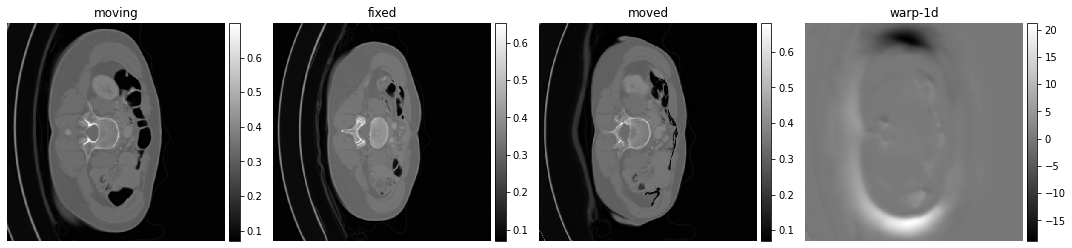

In [11]:
import neurite as ne
# images = [img[0, :, :, 50, 0] for img in in_sample + out_sample]
images = [moving[0, :, :, 50, 0], fixed[0, :, :, 50, 0], moved[0, :, :, 50, 0], warp[0, :, :, 50, 0]]
for img in images:
    print(img.shape)
titles = ['moving', 'fixed', 'moved', 'warp-1d']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [22]:
tmp = warp[0, :, :, 50, 0:2]
tmp.shape

(512, 512, 2)

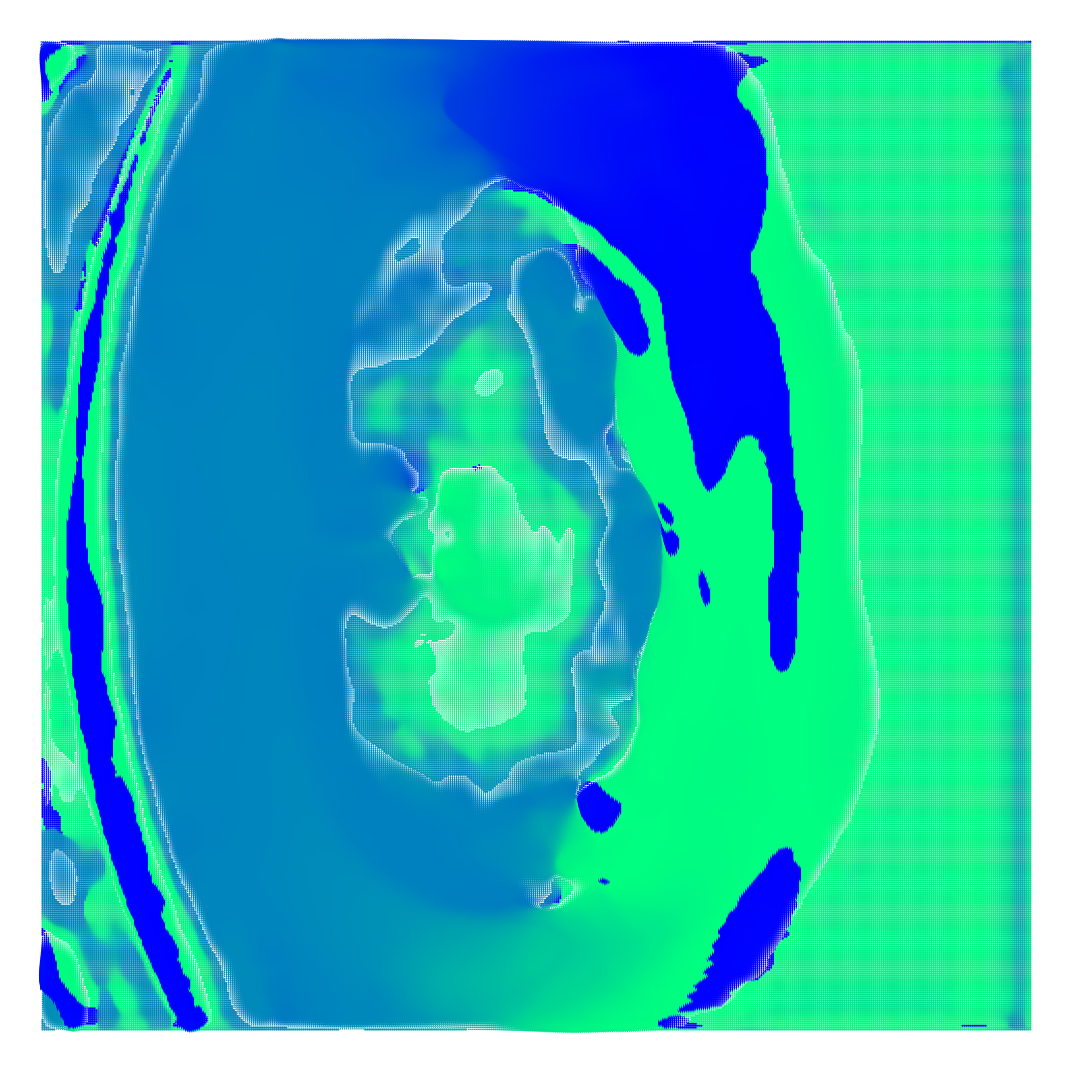

(<Figure size 1080x1080 with 1 Axes>, [<AxesSubplot:>])

In [23]:
ne.plot.flow([tmp])

In [ ]:
# save warp
if args.warp:
    vxm.py.utils.save_volfile(warp.squeeze(), args.warp, fixed_affine)

# save moved image
vxm.py.utils.save_volfile(moved.squeeze(), args.moved, fixed_affine)